# Step 3: Feature Engineering

In [1]:
# Import modules
import pandas as pd
import numpy as np
import ast
from pandas import json_normalize

In [2]:
# Load preprocessed data
yelp_df_business = pd.read_csv('../data/processed_data/preprocessed_business.csv')
yelp_df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"['Local Services', 'Mailbox Centers', 'Notarie...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","['Department Stores', 'Electronics', 'Fashion'...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [3]:
processed_data = yelp_df_business.copy()
processed_data.shape

(117618, 14)

### Our target variable to define whether a business would be successfull or not
**Approach 1:** The stars can be our target variable, but solely stars cannot define the success, since if 1 review is a 5 star rating then it hasn't reached the crowd yet

**Approach 2:** The stars combined with review count can be a good scale to measure the eventual success of a business

#### Since Approach 2 is more holistic, we will combine the star rating and review count into a single metric. Multiply the star rating by the logarithm of the review count to give more weight to businesses with higher ratings and a significant number of reviews.



In [4]:
# This formula ensures that businesses with higher ratings and more reviews get a higher composite rating, reflecting a higher level of success.
processed_data["composite_rating"] = processed_data.stars * np.log(processed_data.review_count + 1)
processed_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,composite_rating
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"['Local Services', 'Mailbox Centers', 'Notarie...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",8.317766
1,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","['Department Stores', 'Electronics', 'Fashion'...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",10.974230


In [5]:
# Remove old columns
# processed_data = processed_data.drop(columns=['stars', 'review_count'])
processed_data.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'composite_rating'],
      dtype='object')

### Operational hours
The hours columns gives a dictionary with hours the business is open for each day in a week. This can be used into our modelling by computing total number of operational hours in a week

In [6]:
from datetime import datetime

def operational_hours(hours: dict = None):
    if not hours:
        return None
    operational_seconds = 0
    for day, time in hours.items():
        start_time_str, end_time_str = time.split('-')
        start_time = datetime.strptime(start_time_str, '%H:%M')
        end_time = datetime.strptime(end_time_str, '%H:%M')
        if end_time < start_time:
            operational_seconds += 24*3600 - (start_time - end_time).total_seconds()
        else:
            operational_seconds += (end_time - start_time).total_seconds()
        
    return operational_seconds/3600

In [7]:
processed_data["hours"] = processed_data["hours"].apply(lambda x: ast.literal_eval(x))
processed_data["operational_hours"] = processed_data["hours"].apply(operational_hours)
processed_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,composite_rating,operational_hours
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"['Local Services', 'Mailbox Centers', 'Notarie...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",8.317766,48.0
1,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","['Department Stores', 'Electronics', 'Fashion'...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",10.974230,100.0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","['Bakeries', 'Bubble Tea', 'Coffee & Tea', 'Fo...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",17.577797,94.0
3,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","['Breweries', 'Brewpubs', 'Food']","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",11.875758,40.0
4,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","['Burgers', 'Fast Food', 'Food', 'Ice Cream & ...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",3.891820,90.0


Adding EveryWeekDay hours

In [8]:
for col in processed_data.columns:
    if col.startswith('hours_'):
        processed_data[col] = processed_data[col].replace('0:0-0:0', pd.NaT)

# Handle missing values or fill with defaults if necessary
processed_data.fillna({'hours_Monday': 'Closed', 'hours_Tuesday': 'Closed', 'hours_Wednesday': 'Closed','hours_Thursday': 'Closed','hours_Friday': 'Closed','hours_Saturday': 'Closed','hours_Sunday': 'Closed'}, inplace=True)

### Categories

In [9]:
processed_data['categories'] = processed_data.categories.apply(lambda x: ast.literal_eval(x))

In [10]:
tag_columns = pd.get_dummies(processed_data.categories.apply(pd.Series).stack()).sum(level=0)
tag_columns

/var/folders/bc/h9rkp5w90dl2mrjc0x7tltdw0000gn/T/ipykernel_55842/3913362731.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tag_columns = pd.get_dummies(processed_data.categories.apply(pd.Series).stack()).sum(level=0)


,& Probates,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Acupuncture,Addiction Medicine,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
all_tags = tag_columns.astype(bool).sum(axis=0).sort_values(ascending=False)
all_tags.head(20)

Restaurants                  44676
Food                         23910
Shopping                     21053
Beauty & Spas                12038
Home Services                11760
Nightlife                    10777
Bars                          9882
Health & Medical              9821
Local Services                9351
Event Planning & Services     8137
Automotive                    8083
Sandwiches                    7623
American (Traditional)        7419
Coffee & Tea                  6186
Pizza                         6026
Fast Food                     5959
Breakfast & Brunch            5861
Active Life                   5842
American (New)                5511
Burgers                       5199
dtype: int64

##### The tags associated with less than 5% of the businesses can be omitted

In [12]:
top_tags = all_tags[all_tags > 0.05 * processed_data.shape[0]]
print(len(all_tags), len(top_tags))

1291 16


In [13]:
top_tag_columns = tag_columns[top_tags.index]
processed_data = pd.concat([processed_data, top_tag_columns], axis=1)
processed_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Bars,Health & Medical,Local Services,Event Planning & Services,Automotive,Sandwiches,American (Traditional),Coffee & Tea,Pizza,Fast Food
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,0,0,1,0,0,0,0,0,0,0
1,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,...,0,0,0,0,0,0,0,0,0,0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,0,0,0,0,0,0,0,1,0,0
3,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,0,0,0,0,0,0,0,0,0,0
4,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,0,0,0,0,0,1,0,0,0,1


### Attributes column

In [14]:
# Define a function to safely evaluate whether the content is a string representation of a dictionary
def safe_eval(x):
    if isinstance(x, dict):
        return x
    try:
        return eval(x)
    except (TypeError, SyntaxError):
        return None

In [15]:
# Apply the safe_eval function to the 'attributes' column and then normalize it
# Note: This is a simplified example. If 'attributes' contains nested dictionaries, you may need a more complex approach
processed_data['attributes'] = processed_data['attributes'].apply(safe_eval)
attributes_expanded = json_normalize(processed_data['attributes'].tolist())
attributes_expanded.head(2)

,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,BusinessParking,WheelchairAccessible,...,AcceptsInsurance,BestNights,BYOB,Corkage,BYOBCorkage,HairSpecializesIn,Open24Hours,RestaurantsCounterService,AgesAllowed,DietaryRestrictions
0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,2,False,False,False,False,u'no',"{'garage': False, 'street': False, 'validated'...",True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
nan_percentage = attributes_expanded.isna().mean() * 100

# Drop columns where NaN percentage is more than 50%
columns_to_drop = nan_percentage[nan_percentage > 50].index
attributes_expanded.drop(columns=columns_to_drop, inplace=True)
attributes_expanded.columns

Index(['BusinessAcceptsCreditCards', 'BikeParking', 'RestaurantsPriceRange2',
       'BusinessParking'],
      dtype='object')

#### BusinessParking expand

In [18]:
attributes_expanded['BusinessParking'] = attributes_expanded['BusinessParking'].apply(safe_eval)
businessparking_expanded = json_normalize(attributes_expanded['BusinessParking'].tolist())
businessparking_expanded.head(2)

,garage,street,validated,lot,valet
0,NaN,NaN,NaN,NaN,NaN
1,False,False,False,True,False


In [19]:
# Join all the new columns
processed_data = pd.concat([processed_data, attributes_expanded, businessparking_expanded], axis=1)

In [20]:
processed_data.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'composite_rating',
       'operational_hours', 'Restaurants', 'Food', 'Shopping', 'Beauty & Spas',
       'Home Services', 'Nightlife', 'Bars', 'Health & Medical',
       'Local Services', 'Event Planning & Services', 'Automotive',
       'Sandwiches', 'American (Traditional)', 'Coffee & Tea', 'Pizza',
       'Fast Food', 'BusinessAcceptsCreditCards', 'BikeParking',
       'RestaurantsPriceRange2', 'BusinessParking', 'garage', 'street',
       'validated', 'lot', 'valet'],
      dtype='object')

##### Cleaning the newly formed features

In [37]:
processed_data.replace({'None': None},inplace=True)
processed_data['BusinessAcceptsCreditCards'].fillna(False, inplace=True)

processed_data.replace({True: 1, False: 0}, inplace=True)
processed_data.replace({'True': 1, 'False': 0}, inplace=True)

processed_data['BusinessAcceptsCreditCards'].value_counts()

1    100642
0     16976
Name: BusinessAcceptsCreditCards, dtype: int64

In [20]:
processed_data.dropna(inplace=True)
features = ["latitude", "longitude", "operational_hours", "is_open", "Restaurants", "Food", "Bars", "garage"]

Feature: 0, Score: -0.05192
Feature: 1, Score: -0.03151
Feature: 2, Score: -0.04583
Feature: 3, Score: 1.68430
Feature: 4, Score: 3.94462
Feature: 5, Score: 0.66103
Feature: 6, Score: 2.56976
Feature: 7, Score: 1.82639


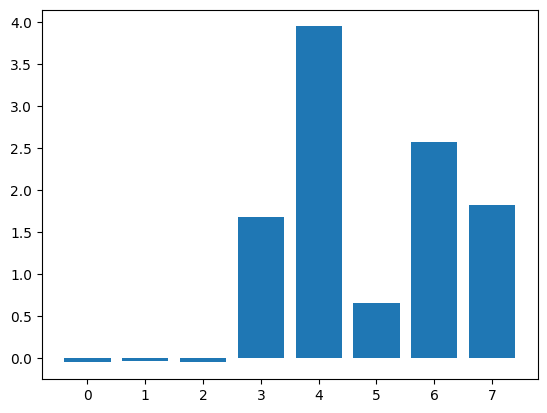

In [21]:
# linear regression feature importance
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X = processed_data[features]
y = processed_data.composite_rating
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance

importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/var/folders/bc/h9rkp5w90dl2mrjc0x7tltdw0000gn/T/ipykernel_50377/131554455.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(processed_data[features].corr().round(2), annot=True)


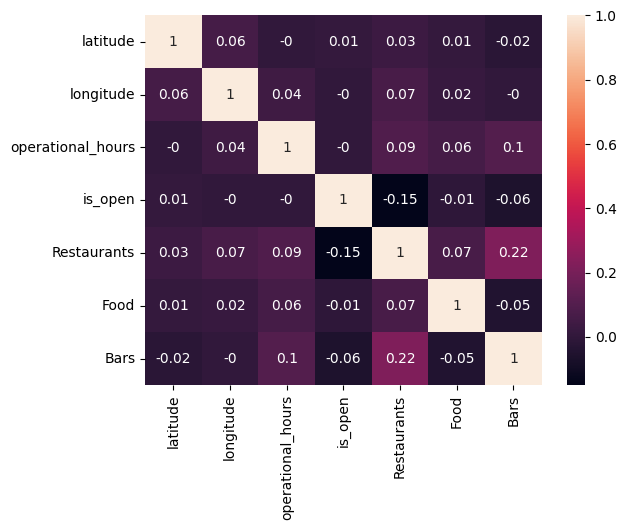

In [22]:
# Load libraries
import matplotlib.pyplot as plt
import seaborn as sns

#ploting the heatmap for correlation
ax = sns.heatmap(processed_data[features].corr().round(2), annot=True) 

# Data normalization

Data normalization ensures fair contribution of features by scaling them to similar ranges, aiding model training, reducing bias, improving convergence, and enhancing interpretability and generalization.

##### For our data we will be using Min-Max normalization

In [23]:
from sklearn.preprocessing import MinMaxScaler

X = processed_data[features]

# scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

# print scaled features
print(scaled_data)

[[0.17894605 0.20262968 0.59565174 ... 0.         0.         0.        ]
 [0.47535279 0.9891873  0.55991264 ... 1.         0.         0.        ]
 [0.42445287 0.65486016 0.2739998  ... 0.         0.         0.        ]
 ...
 [0.32813641 0.73353907 0.38121712 ... 0.         0.         0.        ]
 [0.43038141 0.66344477 0.41695622 ... 0.         0.         0.        ]
 [0.00827529 0.82979807 0.20847811 ... 0.         0.         0.        ]]


In [38]:
processed_data.to_csv("../data/processed_data/train_data_business.csv", index=False)